<a href="https://colab.research.google.com/github/arindamkeswani/RePlicate/blob/main/RePlicate_(HPC_Project).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Observations and assumptions so far:
1. Since an online plag checker would work on a cloud platform, we abandoned local testing in favour of a platform like Colab, as that would give results that are more realistic
2. Major tests done include comparing the execution time taken by:
  1. Serial implementation (for base time)
  2. Multiprocessing library (for base data-parallelism time)
  3. Psuedo data-parallelism (purely for research portion)
  4. Numba library (for potential in-built optimum time)

3. Other libraries, such as iparallel are performing worse than expected, and worse than serial implementation, so they were left out of the final analysis
4. Text files will be fed as input to the program (to be serially or manually converted beforehand since this project focusses of parallel plagiarism, detection, not conversion)

5. Final output will consist of two parts from the perspective of:
 1. Product: Dataframe/spreadsheet type structure, showing level of plagiarism between files
 2. Reasearch: A time/speed-up based comparison between the aforementioned methodologies.

 Original outcome expected data parallelism to perform better, but that is not the case, hence a black implemetation had to be adopted for successful completion.

6. Files are either in .pdf or .txt format

---

Implementation:
1. First part involves building the plag-checker and applying the various devised methodologies.
2. The next step is building a PDF-to-text converter. The goal is to build a simple converter but if time permits, it will be implemented in parallel. 
3. The aim of the project is to create the first two modules. Future implementation will involve integrating the two modules together.

In [1]:
from google.colab import files 
uploaded = files.upload()

Saving Capitalism.pdf to Capitalism.pdf
Saving Caste1.pdf to Caste1.pdf
Saving Cloud1.pdf to Cloud1.pdf
Saving Cloud2.pdf to Cloud2.pdf
Saving Cloud3(Lang).pdf to Cloud3(Lang).pdf
Saving fatma.txt to fatma.txt
Saving Foucault1.pdf to Foucault1.pdf
Saving Foucault2.pdf to Foucault2.pdf
Saving Foucault3.pdf to Foucault3.pdf
Saving Foucault4.pdf to Foucault4.pdf
Saving Foucault5.pdf to Foucault5.pdf
Saving Foucault6.pdf to Foucault6.pdf
Saving Foucault7.pdf to Foucault7.pdf
Saving Foucault8.pdf to Foucault8.pdf
Saving Foucault9.pdf to Foucault9.pdf
Saving Gender1.pdf to Gender1.pdf
Saving john.txt to john.txt
Saving juma.txt to juma.txt
Saving ML1.pdf to ML1.pdf
Saving ML2.pdf to ML2.pdf
Saving PatFem1.txt to PatFem1.txt
Saving PatFem3.pdf to PatFem3.pdf
Saving PatFem4.pdf to PatFem4.pdf
Saving Web1.pdf to Web1.pdf
Saving Web2.pdf to Web2.pdf
Saving Web3.pdf to Web3.pdf


# **Module 1: Plag-checker**

In [120]:
import os
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np
import time
import pandas as pd
from numba import jit
from numba import njit
# from numba.typed import List
from os import system
import sys
from numpy import dot #Alt for cosine similarity
from numpy.linalg import norm #Alt for cosine similarity

In [60]:
student_files = [doc for doc in os.listdir() if doc.endswith('.txt')] #store all text files
student_notes =[open(File).read() for File in  student_files] #stores all lines of all files

In [61]:
vectorize = lambda Text: TfidfVectorizer().fit_transform(Text).toarray()  #to vectorize the words of text files
# similarity = lambda doc1, doc2: cosine_similarity([doc1, doc2]) #to store similarity of two documents

In [63]:
vectors = vectorize(student_notes) #store vectorized values
s_vectors = list(zip(student_files, vectors)) #store it with file names
# plagiarism_results = set() #to store results in a set
plagiarism_results =[]
# s_vectors

In [ ]:
def similarity(doc1, doc2):
  return cosine_similarity([doc1, doc2])

In [155]:
def check_plagiarism(s_vectors_partial):
    # similarity = lambda doc1, doc2: cosine_similarity([doc1, doc2]) #to store similarity of two documents
    plagiarism_results =[]
    
    sys.stdout.write("\r"+"Starting process...")
    global s_vectors
    for student_a, text_vector_a in s_vectors_partial:  #traverse through students and their vectors (for first document)
        # print(f"Started testing:{student_a}")
        # print("Started testing:",student_a)
        sys.stdout.write("\r"+"Started testing:"+student_a) # Cursor up one line
        # time.sleep(1)
        new_vectors = s_vectors.copy() 
        
        # current_index = new_vectors.index((student_a, text_vector_a))
        # del new_vectors[current_index]
        

        for student_b , text_vector_b in new_vectors: #traverse through students and their vectors (for second document)
            # print(f"Testing {student_a} against {student_b}")
            # print("Testing",student_a,"against",student_b)
            sys.stdout.write("\r"+"Testing: "+student_a+" | Against: "+student_b) # Cursor up one line
            # time.sleep(1)
            # sim_score = similarity(text_vector_a, text_vector_b)[0][1] #calculate similarity of both documents
            sim_score = dot(text_vector_a, text_vector_b)/(norm(text_vector_a)*norm(text_vector_b))
            # sim_score = cosine_similarity([text_vector_a, text_vector_b])[0][1]#########################Uncomment it later
            # student_pair = sorted((student_a, student_b)) 
            student_pair = (student_a, student_b) 
            # score = (student_pair[0], student_pair[1],sim_score)
            score = [student_pair[0], student_pair[1],sim_score]
            # plagiarism_results.add(score) #add score with file names into the set
            plagiarism_results.append(score)
            # print("Finished testing",student_a,"against",student_b)
        sys.stdout.write("\r"+"Finished testing: "+student_a)
        sys.stdout.write("\r")
        # print()
    sys.stdout.write("\r"+"Testing complete!")
    return plagiarism_results  
    # return createTable(plagiarism_results)

def createTable(ans):
    df=pd.DataFrame(np.zeros((len(student_files),len(student_files))),index=student_files,columns=student_files)

    for data in ans:
      for rowName in range(len(student_files)):
        if df.index[rowName]==data[0]:
          r=rowName
          for colName in range(len(student_files)):
            if df.index[colName]==data[1]:
              c=colName

              df.iloc[r,c] = data[2]
    return df

In [156]:
#Serial
%%time
start=time.time()
ans=check_plagiarism(s_vectors)
# df=createTable(ans)

end=time.time()
print()
print("Time taken:", end-start)

Testing complete!
Time taken: 0.12113785743713379
CPU times: user 122 ms, sys: 102 ms, total: 224 ms
Wall time: 121 ms


In [133]:
df=createTable(ans)
df

,ML2.txt,Cloud3(Lang).txt,Foucault6.txt,Foucault5.txt,Cloud2.txt,Web1.txt,PatFem4.txt,Web3.txt,fatma.txt,john.txt,Foucault2.txt,PatFem3.txt,Foucault3.txt,Foucault4.txt,PatFem1.txt,ML1.txt,juma.txt,Capitalism.txt,Foucault7.txt,Cloud1.txt,Foucault9.txt,Foucault8.txt,Caste1.txt,Foucault1.txt,Gender1.txt
ML2.txt,1.000000,0.006942,0.021458,0.033483,0.030286,0.002764,0.028455,0.000615,0.009660,0.004839,0.027425,0.003126,0.030992,0.023216,0.029122,0.034130,0.010623,0.029402,0.027387,0.003277,NaN,0.026716,NaN,0.024067,0.025556
Cloud3(Lang).txt,0.006942,1.000000,0.054286,0.085215,0.457563,0.016757,0.069275,0.010844,0.026187,0.004377,0.073529,0.008577,0.073206,0.054432,0.064969,0.074949,0.014607,0.067696,0.066485,0.025152,NaN,0.069920,NaN,0.103261,0.066918
Foucault6.txt,0.021458,0.054286,1.000000,0.607855,0.454652,0.070970,0.571553,0.005841,0.150095,0.112699,0.681483,0.096517,0.647305,0.442732,0.547856,0.485406,0.198536,0.543767,0.600071,0.008982,NaN,0.581735,NaN,0.627931,0.462112
Foucault5.txt,0.033483,0.085215,0.607855,1.000000,0.635363,0.067974,0.751743,0.006656,0.144367,0.068525,0.814746,0.146349,0.857526,0.565641,0.744718,0.697170,0.141842,0.723107,0.794474,0.014363,NaN,0.704550,NaN,0.760234,0.712792
Cloud2.txt,0.030286,0.457563,0.454652,0.635363,1.000000,0.061486,0.619661,0.006477,0.143881,0.124364,0.669691,0.111194,0.679152,0.488850,0.610064,0.622241,0.132477,0.585251,0.655399,0.030432,NaN,0.591180,NaN,0.605148,0.584778
Web1.txt,0.002764,0.016757,0.070970,0.067974,0.061486,1.000000,0.062773,0.011042,0.013045,0.004873,0.064630,0.009887,0.062012,0.046931,0.058328,0.075462,0.009302,0.053358,0.060913,0.001422,NaN,0.063849,NaN,0.054694,0.049335
PatFem4.txt,0.028455,0.069275,0.571553,0.751743,0.619661,0.062773,1.000000,0.006949,0.177197,0.087084,0.786851,0.130756,0.787350,0.535520,0.742001,0.663265,0.151934,0.685977,0.756403,0.012555,NaN,0.695869,NaN,0.722641,0.680775
Web3.txt,0.000615,0.010844,0.005841,0.006656,0.006477,0.011042,0.006949,1.000000,0.009670,0.004277,0.008609,0.000000,0.005980,0.004854,0.007542,0.006684,0.000000,0.005556,0.005645,0.000726,NaN,0.005712,NaN,0.005312,0.006684
fatma.txt,0.009660,0.026187,0.150095,0.144367,0.143881,0.013045,0.177197,0.009670,1.000000,0.128376,0.189517,0.000000,0.142192,0.123334,0.169152,0.139805,0.169166,0.143531,0.148504,0.001498,NaN,0.159551,NaN,0.152336,0.122956
john.txt,0.004839,0.004377,0.112699,0.068525,0.124364,0.004873,0.087084,0.004277,0.128376,1.000000,0.100354,0.000000,0.096497,0.049999,0.080068,0.063285,0.635505,0.076643,0.090136,0.001253,NaN,0.090645,NaN,0.096968,0.053648




---

Parallel [Manual] approach

Ways to achieve data parallelism:
1. Divide s_vectors in parts (more likely)
2. Divide s_vectors[0][1] in parts (potential)

In [172]:
#Parallel [Manual] Part 1
%%time
start=time.time()
ans=check_plagiarism(s_vectors[:len(s_vectors)//2])

# for data in ans:
#     print(data)
# print(createTable(ans))
end=time.time()
print()
print("Time taken:", end-start)

Testing complete!
Time taken: 0.08278465270996094
CPU times: user 81.1 ms, sys: 56.3 ms, total: 137 ms
Wall time: 82.9 ms


In [173]:
dfm1=createTable(ans)
dfm1[:len(dfm1)//2][:]

,ML2.txt,Cloud3(Lang).txt,Foucault6.txt,Foucault5.txt,Cloud2.txt,Web1.txt,PatFem4.txt,Web3.txt,fatma.txt,john.txt,Foucault2.txt,PatFem3.txt,Foucault3.txt,Foucault4.txt,PatFem1.txt,ML1.txt,juma.txt,Capitalism.txt,Foucault7.txt,Cloud1.txt,Foucault9.txt,Foucault8.txt,Caste1.txt,Foucault1.txt,Gender1.txt
ML2.txt,1.000000,0.006942,0.021458,0.033483,0.030286,0.002764,0.028455,0.000615,0.009660,0.004839,0.027425,0.003126,0.030992,0.023216,0.029122,0.034130,0.010623,0.029402,0.027387,0.003277,NaN,0.026716,NaN,0.024067,0.025556
Cloud3(Lang).txt,0.006942,1.000000,0.054286,0.085215,0.457563,0.016757,0.069275,0.010844,0.026187,0.004377,0.073529,0.008577,0.073206,0.054432,0.064969,0.074949,0.014607,0.067696,0.066485,0.025152,NaN,0.069920,NaN,0.103261,0.066918
Foucault6.txt,0.021458,0.054286,1.000000,0.607855,0.454652,0.070970,0.571553,0.005841,0.150095,0.112699,0.681483,0.096517,0.647305,0.442732,0.547856,0.485406,0.198536,0.543767,0.600071,0.008982,NaN,0.581735,NaN,0.627931,0.462112
Foucault5.txt,0.033483,0.085215,0.607855,1.000000,0.635363,0.067974,0.751743,0.006656,0.144367,0.068525,0.814746,0.146349,0.857526,0.565641,0.744718,0.697170,0.141842,0.723107,0.794474,0.014363,NaN,0.704550,NaN,0.760234,0.712792
Cloud2.txt,0.030286,0.457563,0.454652,0.635363,1.000000,0.061486,0.619661,0.006477,0.143881,0.124364,0.669691,0.111194,0.679152,0.488850,0.610064,0.622241,0.132477,0.585251,0.655399,0.030432,NaN,0.591180,NaN,0.605148,0.584778
Web1.txt,0.002764,0.016757,0.070970,0.067974,0.061486,1.000000,0.062773,0.011042,0.013045,0.004873,0.064630,0.009887,0.062012,0.046931,0.058328,0.075462,0.009302,0.053358,0.060913,0.001422,NaN,0.063849,NaN,0.054694,0.049335
PatFem4.txt,0.028455,0.069275,0.571553,0.751743,0.619661,0.062773,1.000000,0.006949,0.177197,0.087084,0.786851,0.130756,0.787350,0.535520,0.742001,0.663265,0.151934,0.685977,0.756403,0.012555,NaN,0.695869,NaN,0.722641,0.680775
Web3.txt,0.000615,0.010844,0.005841,0.006656,0.006477,0.011042,0.006949,1.000000,0.009670,0.004277,0.008609,0.000000,0.005980,0.004854,0.007542,0.006684,0.000000,0.005556,0.005645,0.000726,NaN,0.005712,NaN,0.005312,0.006684
fatma.txt,0.009660,0.026187,0.150095,0.144367,0.143881,0.013045,0.177197,0.009670,1.000000,0.128376,0.189517,0.000000,0.142192,0.123334,0.169152,0.139805,0.169166,0.143531,0.148504,0.001498,NaN,0.159551,NaN,0.152336,0.122956
john.txt,0.004839,0.004377,0.112699,0.068525,0.124364,0.004873,0.087084,0.004277,0.128376,1.000000,0.100354,0.000000,0.096497,0.049999,0.080068,0.063285,0.635505,0.076643,0.090136,0.001253,NaN,0.090645,NaN,0.096968,0.053648


In [170]:
#Parallel [Manual] Part 2
%%time
start=time.time()
ans=check_plagiarism(s_vectors[len(s_vectors)//2:])

# for data in ans:
#     print(data)
# print(createTable(ans))
end=time.time()
print()
print("Time taken:", end-start)

Testing complete!
Time taken: 0.08042359352111816
CPU times: user 74 ms, sys: 67 ms, total: 141 ms
Wall time: 80.5 ms


In [171]:
dfm2=createTable(ans)
dfm2[len(dfm1)//2:][:]

,ML2.txt,Cloud3(Lang).txt,Foucault6.txt,Foucault5.txt,Cloud2.txt,Web1.txt,PatFem4.txt,Web3.txt,fatma.txt,john.txt,Foucault2.txt,PatFem3.txt,Foucault3.txt,Foucault4.txt,PatFem1.txt,ML1.txt,juma.txt,Capitalism.txt,Foucault7.txt,Cloud1.txt,Foucault9.txt,Foucault8.txt,Caste1.txt,Foucault1.txt,Gender1.txt
Foucault3.txt,0.030992,0.073206,0.647305,0.857526,0.679152,0.062012,0.787350,0.005980,0.142192,0.096497,0.898707,0.165683,1.000000,0.617763,0.776804,0.725300,0.150673,0.768204,0.861014,0.014446,NaN,0.790187,NaN,0.799914,0.730106
Foucault4.txt,0.023216,0.054432,0.442732,0.565641,0.488850,0.046931,0.535520,0.004854,0.123334,0.049999,0.625890,0.099746,0.617763,1.000000,0.512444,0.498976,0.102092,0.507460,0.581253,0.009869,NaN,0.568029,NaN,0.536953,0.475803
PatFem1.txt,0.029122,0.064969,0.547856,0.744718,0.610064,0.058328,0.742001,0.007542,0.169152,0.080068,0.777582,0.139181,0.776804,0.512444,1.000000,0.649388,0.133417,0.682798,0.757573,0.012312,NaN,0.659252,NaN,0.695551,0.730544
ML1.txt,0.034130,0.074949,0.485406,0.697170,0.622241,0.075462,0.663265,0.006684,0.139805,0.063285,0.705368,0.129755,0.725300,0.498976,0.649388,1.000000,0.118308,0.626451,0.697781,0.013042,NaN,0.612372,NaN,0.650314,0.626239
juma.txt,0.010623,0.014607,0.198536,0.141842,0.132477,0.009302,0.151934,0.000000,0.169166,0.635505,0.163035,0.000000,0.150673,0.102092,0.133417,0.118308,1.000000,0.136175,0.139888,0.002528,NaN,0.162404,NaN,0.182715,0.085748
Capitalism.txt,0.029402,0.067696,0.543767,0.723107,0.585251,0.053358,0.685977,0.005556,0.143531,0.076643,0.759460,0.138479,0.768204,0.507460,0.682798,0.626451,0.136175,1.000000,0.745387,0.012571,NaN,0.645172,NaN,0.697979,0.645590
Foucault7.txt,0.027387,0.066485,0.600071,0.794474,0.655399,0.060913,0.756403,0.005645,0.148504,0.090136,0.851785,0.157770,0.861014,0.581253,0.757573,0.697781,0.139888,0.745387,1.000000,0.013086,NaN,0.738511,NaN,0.761664,0.721498
Cloud1.txt,0.003277,0.025152,0.008982,0.014363,0.030432,0.001422,0.012555,0.000726,0.001498,0.001253,0.013511,0.001777,0.014446,0.009869,0.012312,0.013042,0.002528,0.012571,0.013086,1.000000,NaN,0.011969,NaN,0.011573,0.012973
Foucault9.txt,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Foucault8.txt,0.026716,0.069920,0.581735,0.704550,0.591180,0.063849,0.695869,0.005712,0.159551,0.090645,0.805210,0.117845,0.790187,0.568029,0.659252,0.612372,0.162404,0.645172,0.738511,0.011969,NaN,1.000000,NaN,0.689032,0.613431




---





---

Multiprocessing approach

In [163]:
# s_vectors[:len(s_vectors)//2]

In [164]:
#Multiprocessing approach
%%time
import multiprocessing
import os

# def worker1(func1): 
#   func1(m)
  

start=time.time()

pool = multiprocessing.Pool(processes=2) 



l1 = s_vectors[:len(s_vectors)//2]
l2 = s_vectors[len(s_vectors)//2:]

start=time.time()

result = pool.map(check_plagiarism, [l1,l2])

for i in result:
  print(i)

# print(createTable(result))
# print(result)

end=time.time()

# ty.append("Multiprocessing [50000 elements]")
# t.append(end-start)

print("Time taken: ",end-start)

[['ML2.txt', 'ML2.txt', 1.0], ['ML2.txt', 'Cloud3(Lang).txt', 0.006941697746667446], ['ML2.txt', 'Foucault6.txt', 0.02145794434123781], ['ML2.txt', 'Foucault5.txt', 0.033482782650028214], ['ML2.txt', 'Cloud2.txt', 0.030286316067156406], ['ML2.txt', 'Web1.txt', 0.0027643853664433026], ['ML2.txt', 'PatFem4.txt', 0.02845493244470549], ['ML2.txt', 'Web3.txt', 0.0006145967349186383], ['ML2.txt', 'fatma.txt', 0.009659846290115598], ['ML2.txt', 'john.txt', 0.00483907455598717], ['ML2.txt', 'Foucault2.txt', 0.027425395423077818], ['ML2.txt', 'PatFem3.txt', 0.003125508283954523], ['ML2.txt', 'Foucault3.txt', 0.030991933589629914], ['ML2.txt', 'Foucault4.txt', 0.02321627475767797], ['ML2.txt', 'PatFem1.txt', 0.029122462991490652], ['ML2.txt', 'ML1.txt', 0.034129708770866414], ['ML2.txt', 'juma.txt', 0.010623444161978478], ['ML2.txt', 'Capitalism.txt', 0.029401913712944726], ['ML2.txt', 'Foucault7.txt', 0.027387252492448628], ['ML2.txt', 'Cloud1.txt', 0.0032768741401439693], ['ML2.txt', 'Foucault



---

Numba approach

In [81]:
#Numba approach
from numba.core.errors import NumbaDeprecationWarning, NumbaPendingDeprecationWarning
import warnings

warnings.simplefilter('ignore', category=NumbaDeprecationWarning)
warnings.simplefilter('ignore', category=NumbaPendingDeprecationWarning)

In [166]:
%%time
start=time.time()
# try:

num_res= jit(parallel=True)(check_plagiarism)


end=time.time()


CPU times: user 395 µs, sys: 0 ns, total: 395 µs
Wall time: 408 µs


In [168]:
%%time
a=num_res(s_vectors)

Testing complete!CPU times: user 102 ms, sys: 78.2 ms, total: 180 ms
Wall time: 97.5 ms


In [84]:
#Convert set into
print("Time taken: ", end-start)

Time taken:  0.0034132003784179688


In [169]:
df2=createTable(a)
df2

,ML2.txt,Cloud3(Lang).txt,Foucault6.txt,Foucault5.txt,Cloud2.txt,Web1.txt,PatFem4.txt,Web3.txt,fatma.txt,john.txt,Foucault2.txt,PatFem3.txt,Foucault3.txt,Foucault4.txt,PatFem1.txt,ML1.txt,juma.txt,Capitalism.txt,Foucault7.txt,Cloud1.txt,Foucault9.txt,Foucault8.txt,Caste1.txt,Foucault1.txt,Gender1.txt
ML2.txt,1.000000,0.006942,0.021458,0.033483,0.030286,0.002764,0.028455,0.000615,0.009660,0.004839,0.027425,0.003126,0.030992,0.023216,0.029122,0.034130,0.010623,0.029402,0.027387,0.003277,NaN,0.026716,NaN,0.024067,0.025556
Cloud3(Lang).txt,0.006942,1.000000,0.054286,0.085215,0.457563,0.016757,0.069275,0.010844,0.026187,0.004377,0.073529,0.008577,0.073206,0.054432,0.064969,0.074949,0.014607,0.067696,0.066485,0.025152,NaN,0.069920,NaN,0.103261,0.066918
Foucault6.txt,0.021458,0.054286,1.000000,0.607855,0.454652,0.070970,0.571553,0.005841,0.150095,0.112699,0.681483,0.096517,0.647305,0.442732,0.547856,0.485406,0.198536,0.543767,0.600071,0.008982,NaN,0.581735,NaN,0.627931,0.462112
Foucault5.txt,0.033483,0.085215,0.607855,1.000000,0.635363,0.067974,0.751743,0.006656,0.144367,0.068525,0.814746,0.146349,0.857526,0.565641,0.744718,0.697170,0.141842,0.723107,0.794474,0.014363,NaN,0.704550,NaN,0.760234,0.712792
Cloud2.txt,0.030286,0.457563,0.454652,0.635363,1.000000,0.061486,0.619661,0.006477,0.143881,0.124364,0.669691,0.111194,0.679152,0.488850,0.610064,0.622241,0.132477,0.585251,0.655399,0.030432,NaN,0.591180,NaN,0.605148,0.584778
Web1.txt,0.002764,0.016757,0.070970,0.067974,0.061486,1.000000,0.062773,0.011042,0.013045,0.004873,0.064630,0.009887,0.062012,0.046931,0.058328,0.075462,0.009302,0.053358,0.060913,0.001422,NaN,0.063849,NaN,0.054694,0.049335
PatFem4.txt,0.028455,0.069275,0.571553,0.751743,0.619661,0.062773,1.000000,0.006949,0.177197,0.087084,0.786851,0.130756,0.787350,0.535520,0.742001,0.663265,0.151934,0.685977,0.756403,0.012555,NaN,0.695869,NaN,0.722641,0.680775
Web3.txt,0.000615,0.010844,0.005841,0.006656,0.006477,0.011042,0.006949,1.000000,0.009670,0.004277,0.008609,0.000000,0.005980,0.004854,0.007542,0.006684,0.000000,0.005556,0.005645,0.000726,NaN,0.005712,NaN,0.005312,0.006684
fatma.txt,0.009660,0.026187,0.150095,0.144367,0.143881,0.013045,0.177197,0.009670,1.000000,0.128376,0.189517,0.000000,0.142192,0.123334,0.169152,0.139805,0.169166,0.143531,0.148504,0.001498,NaN,0.159551,NaN,0.152336,0.122956
john.txt,0.004839,0.004377,0.112699,0.068525,0.124364,0.004873,0.087084,0.004277,0.128376,1.000000,0.100354,0.000000,0.096497,0.049999,0.080068,0.063285,0.635505,0.076643,0.090136,0.001253,NaN,0.090645,NaN,0.096968,0.053648




---

# **Results**

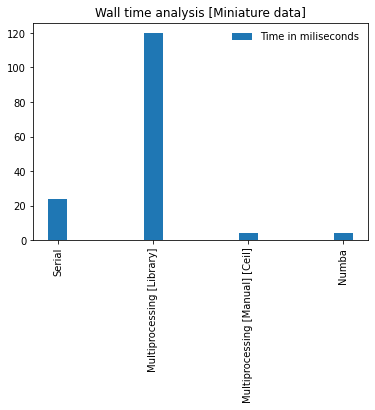

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

t=[23.5, 120, 4.19 , 4.22]
ty=["Serial", "Multiprocessing [Library]", "Psuedo data-parallelism [Ceil]" , "Numba"]
nodes= np.arange(len(t))

plt.bar(nodes,t,width=0.2, align='center' ,label='Time in miliseconds')

plt.title("Wall time analysis [Miniature data = 3 elements]")

plt.xticks(nodes,ty,rotation=90)
plt.legend(loc='best', frameon=False)
plt.show()

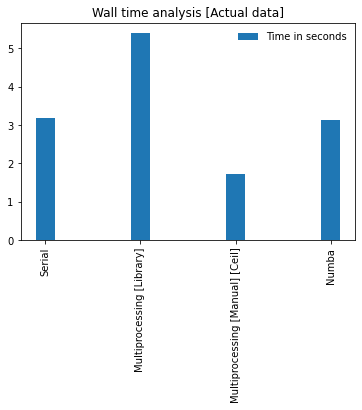

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

t=[3.18 , 5.4, 1.71 , 3.13]
ty=["Serial", "Multiprocessing [Library]", "Psuedo data-parallelism [Ceil]" , "Numba"]
nodes= np.arange(len(t))

plt.bar(nodes,t,width=0.2, align='center' ,label='Time in seconds')

plt.title("Wall time analysis [Actual data=10 files][Create dataframe]")

plt.xticks(nodes,ty,rotation=90)
plt.legend(loc='best', frameon=False)
plt.show()

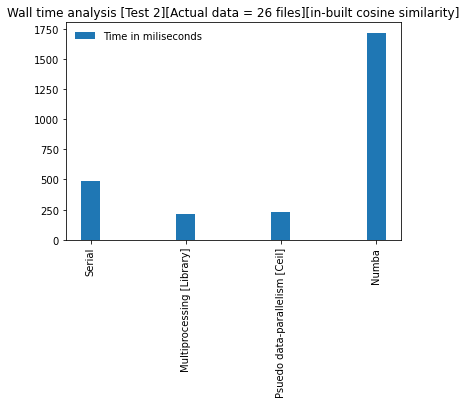

In [176]:
import matplotlib.pyplot as plt
import numpy as np

t=[485 , 212, 233 ,1720]
ty=["Serial", "Multiprocessing [Library]", "Psuedo data-parallelism [Ceil]" , "Numba"]
nodes= np.arange(len(t))

plt.bar(nodes,t,width=0.2, align='center' ,label='Time in miliseconds')

plt.title("Wall time analysis [Test 2][Actual data = 26 files][in-built cosine similarity]")

plt.xticks(nodes,ty,rotation=90)
plt.legend(loc='best', frameon=False)
plt.show()

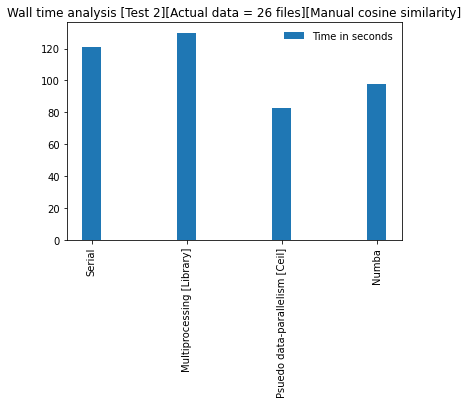

In [175]:
import matplotlib.pyplot as plt
import numpy as np

t=[121 , 130, 82.9 ,97.5]
ty=["Serial", "Multiprocessing [Library]", "Psuedo data-parallelism [Ceil]" , "Numba"]
nodes= np.arange(len(t))

plt.bar(nodes,t,width=0.2, align='center' ,label='Time in seconds')

plt.title("Wall time analysis [Test 2][Actual data = 26 files][Manual cosine similarity]")

plt.xticks(nodes,ty,rotation=90)
plt.legend(loc='best', frameon=False)
plt.show()

# **Module 2: PDF-to-text converter**

In [53]:
pip install PyPDF2

     |████████████████████████████████| 81kB 2.9MB/s 
  Created wheel for PyPDF2: filename=PyPDF2-1.26.0-cp37-none-any.whl size=61085 sha256=2cb0aa35274c96a581f56e42f84fc675413f8ed594fd836decd5744ba6e61a2a
  Stored in directory: /root/.cache/pip/wheels/53/84/19/35bc977c8bf5f0c23a8a011aa958acd4da4bbd7a229315c1b7
Successfully built PyPDF2


In [ ]:
from google.colab import files 
uploaded = files.upload()

Saving Web3.pdf to Web3.pdf
Saving Web2.pdf to Web2.pdf
Saving Web1.pdf to Web1.pdf
Saving Cloud3(Lang).pdf to Cloud3(Lang).pdf
Saving Cloud2.pdf to Cloud2.pdf
Saving Cloud1.pdf to Cloud1.pdf
Saving ML2.pdf to ML2.pdf
Saving ML1.pdf to ML1.pdf


In [56]:
# importing required modules 
import PyPDF2 

In [57]:
student_files_pdf = [doc for doc in os.listdir() if doc.endswith('.pdf')]
student_files_pdf

['Foucault8.pdf',
 'Foucault6.pdf',
 'Web3.pdf',
 'Foucault1.pdf',
 'ML2.pdf',
 'Foucault9.pdf',
 'Gender1.pdf',
 'Foucault5.pdf',
 'Foucault4.pdf',
 'Foucault7.pdf',
 'Web1.pdf',
 'Web2.pdf',
 'Cloud3(Lang).pdf',
 'ML1.pdf',
 'Cloud2.pdf',
 'Cloud1.pdf',
 'Capitalism.pdf',
 'PatFem4.pdf',
 'Foucault3.pdf',
 'PatFem3.pdf',
 'Caste1.pdf',
 'Foucault2.pdf']

In [58]:
# creating a pdf file object 
def convert(path):

  pin='/content/'+path
  print(f"Converting {pin.split('/')[-1]}...")
  pout=pin[:-4]+".txt"
  print(pout)
  pdfFileObj = open(pin, 'rb') 
      
  # creating a pdf reader object 
  pdfReader = PyPDF2.PdfFileReader(pdfFileObj) 
      
  # printing number of pages in pdf file 
  print(f"Number of pages: {pdfReader.numPages}") 
      
  # creating a page object 
  s=""
  for i in range(pdfReader.numPages):
    pageObj = pdfReader.getPage(i) 
      
    # extracting text from page 
    s+=pageObj.extractText()
  print(f"Writing contents of {pin} to {pout}")
  myText = open(pout,'w')

  
  myText.write(s)
  myText.close()
  pdfFileObj.close()
  print('_'*100)

# closing the pdf file object 


In [59]:
for i in student_files_pdf:
  try:
    path=i
    convert(i)
  except:
    print("Cannot convert",i)
    print('_'*100)

Converting Foucault8.pdf...
/content/Foucault8.txt
Number of pages: 7
Writing contents of /content/Foucault8.pdf to /content/Foucault8.txt
____________________________________________________________________________________________________
Converting Foucault6.pdf...
/content/Foucault6.txt
Number of pages: 3
Writing contents of /content/Foucault6.pdf to /content/Foucault6.txt
____________________________________________________________________________________________________
Converting Web3.pdf...
/content/Web3.txt
Number of pages: 8
Writing contents of /content/Web3.pdf to /content/Web3.txt
____________________________________________________________________________________________________
Converting Foucault1.pdf...
/content/Foucault1.txt
Number of pages: 4
Writing contents of /content/Foucault1.pdf to /content/Foucault1.txt
____________________________________________________________________________________________________
Converting ML2.pdf...
/content/ML2.txt


Number of pages: 30
Writing contents of /content/ML2.pdf to /content/ML2.txt
____________________________________________________________________________________________________
Converting Foucault9.pdf...
/content/Foucault9.txt
Number of pages: 36
Writing contents of /content/Foucault9.pdf to /content/Foucault9.txt
____________________________________________________________________________________________________
Converting Gender1.pdf...
/content/Gender1.txt
Number of pages: 4
Writing contents of /content/Gender1.pdf to /content/Gender1.txt
____________________________________________________________________________________________________
Converting Foucault5.pdf...
/content/Foucault5.txt
Number of pages: 15
Writing contents of /content/Foucault5.pdf to /content/Foucault5.txt
____________________________________________________________________________________________________
Converting Foucault4.pdf...
/content/Foucault4.txt
Number of pages: 10
Writing contents of /content/Foucault



---


# **Rough space**

In [113]:
a=[1,2,5,3,4]
b=[1,2,4,5,6]
dot(a, b])/(norm(a)*norm(b))

SyntaxError: ignored

In [ ]:
import sys
import time
for i in range(10):
    a="Loading" + "." * i
    sys.stdout.write("\r"+a) # Cursor up one line
    time.sleep(1)

Loading.........

In [ ]:
for data in ans:
  for rowName in range(len(student_files)):
    if df.index[rowName]==data[0]:
      r=rowName
      for colName in range(len(student_files)):
        if df.index[colName]==data[1]:
          c=colName

          df.iloc[r,c] = data[2]
df

In [ ]:
df=pd.DataFrame(np.zeros((len(student_files),len(student_files))),index=student_files,columns=student_files)
df

In [ ]:
df2=pd.DataFrame(np.zeros((len(student_files),len(student_files))),index=student_files,columns=student_files)
df2

,juma.txt,fatma.txt,john.txt
juma.txt,0.0,0.0,0.0
fatma.txt,0.0,0.0,0.0
john.txt,0.0,0.0,0.0


In [ ]:
for data in a:
  for rowName in range(len(student_files)):
    if df2.index[rowName]==data[0]:
      r=rowName
      for colName in range(len(student_files)):
        if df2.index[colName]==data[1]:
          c=colName

          df2.iloc[r,c] = data[2]
df2

,juma.txt,fatma.txt,john.txt
juma.txt,1.000000,0.186434,0.546597
fatma.txt,0.186434,1.000000,0.148069
john.txt,0.546597,0.148069,1.000000


In [ ]:
from numba import jit


def sq(n):
  s=0
  for i in range(n):
    s+=i**2
  print(s)


In [ ]:
%%time
sq(100000)

333328333350000
CPU times: user 30.7 ms, sys: 0 ns, total: 30.7 ms
Wall time: 31.5 ms


In [ ]:
from numba import jit

# @jit(nopython=True)
def sq2(n):
  s=0
  for i in range(n):
    s+=i**2
  print(s)


In [ ]:
%%time
ans=jit(nopython=True)(sq2)

CPU times: user 238 µs, sys: 28 µs, total: 266 µs
Wall time: 270 µs


In [ ]:
%%time 
ans(100000)

333328333350000
CPU times: user 138 µs, sys: 4 µs, total: 142 µs
Wall time: 101 µs
